<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/Iterative_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example of iterative learning

Best parameters from grid search: {'C': 0.1, 'epsilon': 0.05, 'kernel': 'linear'}

--- Iteration 1 ---
Trained SVR with 5 data points (0 pseudo-labeled).
Validation MSE: 2.6612
Selected 52 high-confidence pseudo-labels (avg uncertainty: 0.1963).

--- Iteration 2 ---
Trained SVR with 57 data points (52 pseudo-labeled).
Validation MSE: 2.4070
Selected 10 high-confidence pseudo-labels (avg uncertainty: 0.2670).

--- Iteration 3 ---
Trained SVR with 67 data points (62 pseudo-labeled).
Validation MSE: 2.4043
Selected 18 high-confidence pseudo-labels (avg uncertainty: 0.2296).

--- Iteration 4 ---
Trained SVR with 85 data points (80 pseudo-labeled).
Validation MSE: 2.4043
No improvement for 1 iterations.
Selected 8 high-confidence pseudo-labels (avg uncertainty: 0.2720).

--- Iteration 5 ---
Trained SVR with 93 data points (88 pseudo-labeled).
Validation MSE: 2.4043
Selected 6 high-confidence pseudo-labels (avg uncertainty: 0.2902).

--- Iteration 6 ---
Trained SVR with 99 data points (94 ps

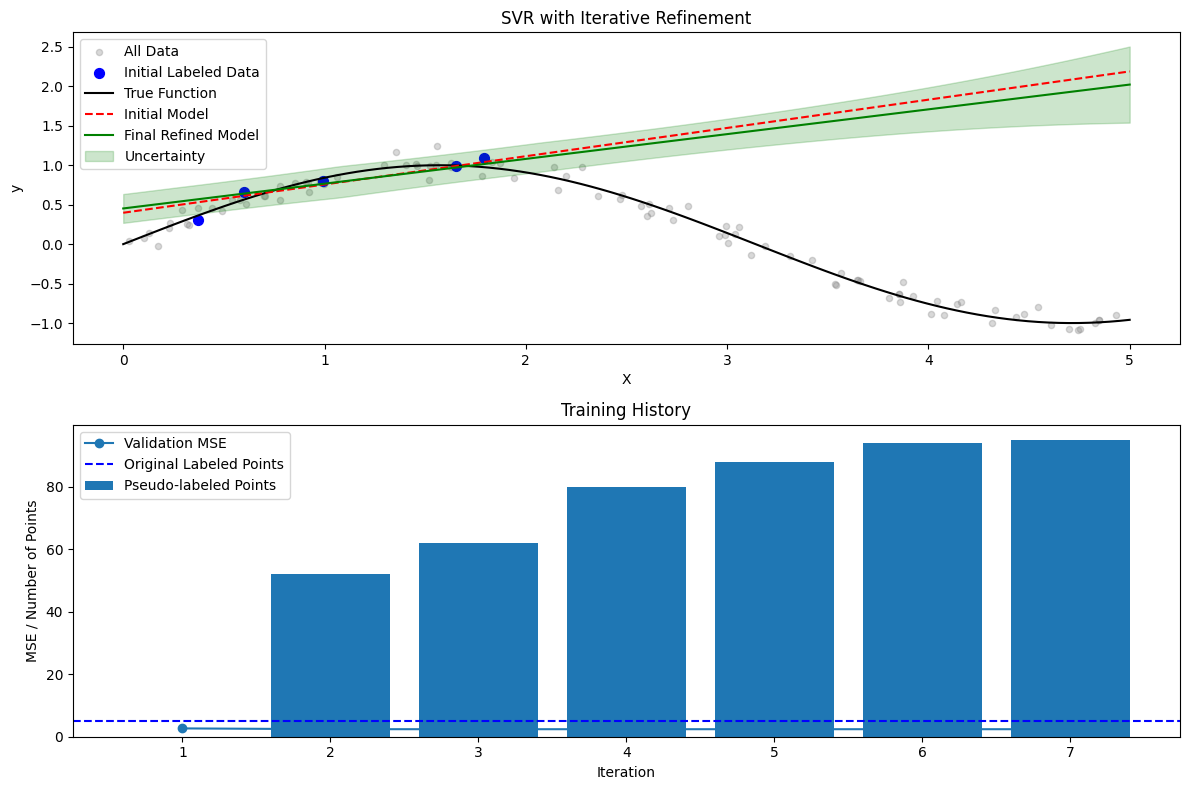


Improvement in MSE: 9.30%
Improvement in R²: 41.02 percentage points
Number of pseudo-labels used: 1
Ratio of pseudo-labels to initial labels: 0.20

--- Applying to a more realistic dataset example ---
Training with 20 labeled and 220 unlabeled points

--- Iteration 1 ---
Trained SVR with 20 data points (0 pseudo-labeled).
Validation MSE: 0.0408
Selected 174 high-confidence pseudo-labels (avg uncertainty: 0.1879).

--- Iteration 2 ---
Trained SVR with 194 data points (174 pseudo-labeled).
Validation MSE: 0.0408
No improvement for 1 iterations.
Selected 2 high-confidence pseudo-labels (avg uncertainty: 0.3036).

--- Iteration 3 ---
Trained SVR with 196 data points (176 pseudo-labeled).
Validation MSE: 0.0407
No more unlabeled data.
Using best model from iteration with validation MSE: 0.0407
Simple Model MSE: 0.0537, R²: 0.8738
Refined Model MSE: 0.0545, R²: 0.8719
Improvement: -1.53%


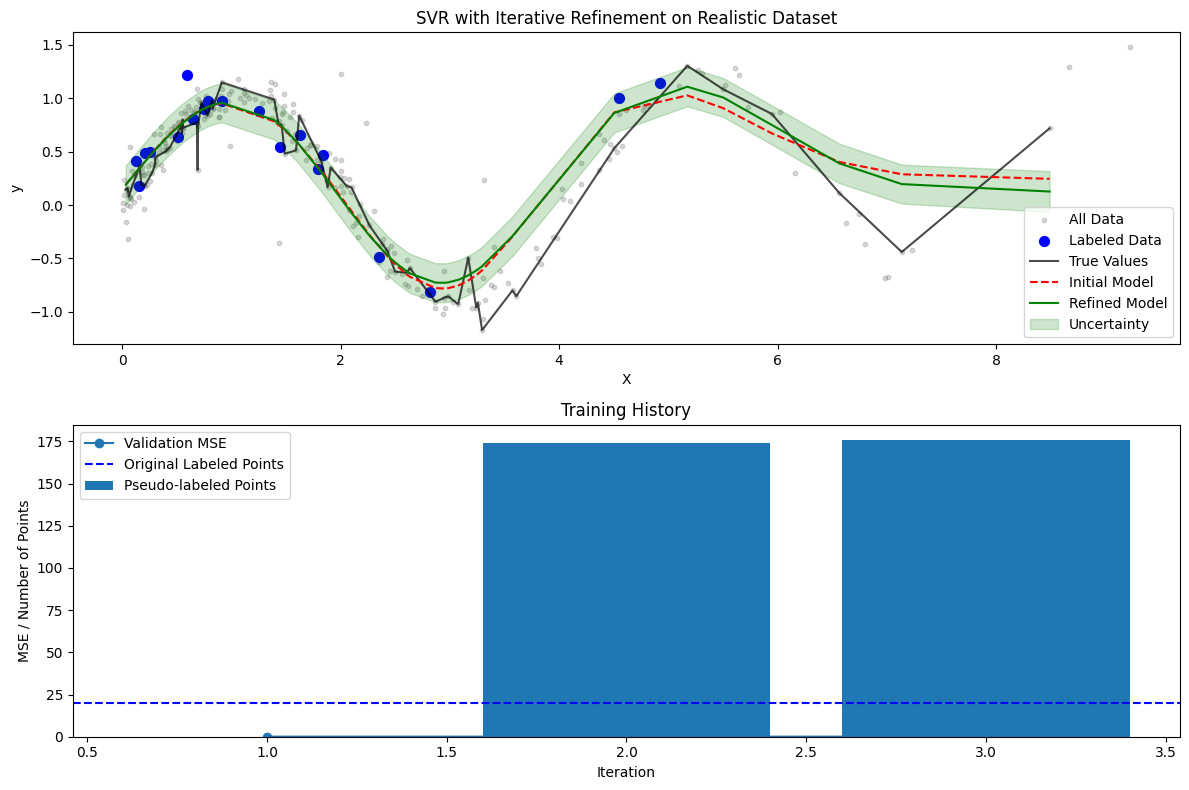

In [14]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


def train_svr(X, y, C=1.0, epsilon=0.1, kernel='rbf', scaler_type='standard'):
    """Trains an SVR model with choice of scaler.

    Args:
        X: Input features
        y: Target values
        C: Regularization parameter
        epsilon: Epsilon parameter for SVR
        kernel: Kernel type ('rbf', 'linear', 'poly', etc.)
        scaler_type: Type of scaler ('standard' or 'robust')

    Returns:
        model: Trained SVR model
        scaler_X: Fitted scaler for input features
    """
    # Choose scaler based on parameter
    if scaler_type == 'robust':
        scaler_X = RobustScaler()
    else:
        scaler_X = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(X_scaled, y)

    # Store X for later reference in uncertainty estimation
    model.X = X

    return model, scaler_X


def predict_with_svr(model, scaler_X, X_new):
    """Predicts using a trained SVR model.

    Args:
        model: Trained SVR model
        scaler_X: Fitted scaler for input features
        X_new: New data to predict on

    Returns:
        Predictions for X_new
    """
    X_new_scaled = scaler_X.transform(X_new)
    return model.predict(X_new_scaled)


def estimate_uncertainty_svr(model, scaler_X, X_predict):
    """Estimates uncertainty for SVR predictions based on distance to support vectors.

    This approach uses the distance to nearest support vector as a proxy for
    prediction uncertainty. Points far from any support vector will have higher uncertainty.

    Args:
        model: Trained SVR model
        scaler_X: Fitted scaler for input features
        X_predict: Data points for which to estimate uncertainty

    Returns:
        uncertainty: Uncertainty score for each prediction point
    """
    X_predict_scaled = scaler_X.transform(X_predict)
    support_vectors_scaled = model.support_vectors_

    if support_vectors_scaled.shape[0] > 0:
        # Calculate squared Euclidean distances to all support vectors
        distances = cdist(X_predict_scaled, support_vectors_scaled, metric='sqeuclidean')

        # Find distance to closest support vector for each point
        min_distances = np.min(distances, axis=1)

        # Calculate maximum possible distance for normalization
        # This uses the training data stored in model.X
        max_dist = np.max(cdist(scaler_X.transform(model.X), support_vectors_scaled,
                               metric='sqeuclidean')) if model.X.shape[0] > 0 and support_vectors_scaled.shape[0] > 0 else 1.0

        # Normalize distances to [0, 1] range and apply a sigmoid-like transformation
        # for more intuitive uncertainty values
        uncertainty = 1.0 / (1.0 + np.exp(-3 * (min_distances / (max_dist + 1e-6) - 0.5)))
    else:
        # If no support vectors (unlikely), assign maximum uncertainty
        uncertainty = np.ones(X_predict.shape[0])

    return uncertainty


def weighted_svr_fit(X, y, uncertainties=None, C=1.0, epsilon=0.1, kernel='rbf'):
    """Fits an SVR model with sample weights based on uncertainties.

    Args:
        X: Input features
        y: Target values
        uncertainties: Uncertainty scores for each sample (None for uniform weights)
        C, epsilon, kernel: SVR parameters

    Returns:
        Trained SVR model
    """
    if uncertainties is not None:
        # Convert uncertainties to weights (lower uncertainty -> higher weight)
        sample_weights = 1.0 / (uncertainties + 0.1)  # Adding 0.1 to avoid division by zero

        # Normalize weights to sum to n_samples for stability
        sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)
    else:
        sample_weights = None

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(X_scaled, y, sample_weight=sample_weights)

    # Store X for later reference
    model.X = X

    return model, scaler_X


def iterative_refinement_svr(X_labeled, y_labeled, X_unlabeled, initial_C=1.0, initial_epsilon=0.1,
                             kernel='rbf', uncertainty_threshold=0.5, max_iterations=5,
                             validation_set=None, early_stopping=True, patience=2):
    """Performs iterative refinement using SVR with pseudo-labeling.

    Args:
        X_labeled: Initial labeled feature data
        y_labeled: Initial labeled target values
        X_unlabeled: Unlabeled feature data
        initial_C: Initial C parameter for SVR
        initial_epsilon: Initial epsilon parameter for SVR
        kernel: Kernel type for SVR
        uncertainty_threshold: Threshold below which predictions are considered confident
        max_iterations: Maximum number of refinement iterations
        validation_set: Optional (X_val, y_val) tuple for validation
        early_stopping: Whether to use early stopping
        patience: Number of iterations without improvement before stopping

    Returns:
        final_model: Final trained SVR model
        final_scaler_X: Final scaler for the model
        history: Dictionary with training history metrics
    """
    current_X_train = X_labeled.copy()
    current_y_train = y_labeled.copy()

    # Keep track of unlabeled data and their pseudo-labels and uncertainties
    X_remaining = X_unlabeled.copy()

    # For keeping track of performance history
    history = {
        'iterations': [],
        'num_labeled': [],
        'num_pseudo': [],
        'validation_mse': [],
        'model_params': []
    }

    # For early stopping
    best_val_mse = float('inf')
    no_improvement_count = 0
    best_model = None
    best_scaler = None

    # Store pseudo-labels and their uncertainties for weighted learning
    pseudo_label_data = {
        'X': np.empty((0, X_labeled.shape[1])),
        'y': np.empty(0),
        'uncertainty': np.empty(0)
    }

    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration + 1} ---")

        # Train SVR on the current labeled data
        model, scaler_X = train_svr(current_X_train, current_y_train,
                                   C=initial_C, epsilon=initial_epsilon, kernel=kernel)

        history['iterations'].append(iteration + 1)
        history['num_labeled'].append(len(X_labeled))
        history['num_pseudo'].append(len(current_X_train) - len(X_labeled))
        history['model_params'].append({'C': initial_C, 'epsilon': initial_epsilon, 'kernel': kernel})

        print(f"Trained SVR with {len(current_X_train)} data points "
              f"({len(current_X_train) - len(X_labeled)} pseudo-labeled).")

        # Validate model if validation set is provided
        if validation_set is not None:
            X_val, y_val = validation_set
            y_val_pred = predict_with_svr(model, scaler_X, X_val)
            val_mse = mean_squared_error(y_val, y_val_pred)
            history['validation_mse'].append(val_mse)
            print(f"Validation MSE: {val_mse:.4f}")

            # Check for early stopping
            if early_stopping:
                if val_mse < best_val_mse:
                    best_val_mse = val_mse
                    no_improvement_count = 0
                    best_model = model
                    best_scaler = scaler_X
                else:
                    no_improvement_count += 1
                    print(f"No improvement for {no_improvement_count} iterations.")

                if no_improvement_count >= patience:
                    print(f"Early stopping triggered after {iteration + 1} iterations.")
                    break

        if X_remaining.shape[0] == 0:
            print("No more unlabeled data.")
            break

        # Predict on remaining unlabeled data and estimate uncertainty
        y_predicted = predict_with_svr(model, scaler_X, X_remaining)
        uncertainties = estimate_uncertainty_svr(model, scaler_X, X_remaining)

        # Select high-confidence pseudo-labels (lower uncertainty is higher confidence)
        high_confidence_indices = np.where(uncertainties < uncertainty_threshold)[0]

        if len(high_confidence_indices) == 0:
            print("No high-confidence pseudo-labels found in this iteration.")

            # Adjust uncertainty threshold if no samples were selected
            uncertainty_threshold *= 1.2
            print(f"Increased uncertainty threshold to {uncertainty_threshold:.4f}")

            # If we've tried increasing threshold and still no samples, break
            if uncertainty_threshold > 0.9:
                print("Uncertainty threshold too high. Stopping refinement.")
                break

            continue

        X_pseudo_labeled = X_remaining[high_confidence_indices]
        y_pseudo_labeled = y_predicted[high_confidence_indices]
        uncertainties_selected = uncertainties[high_confidence_indices]

        print(f"Selected {len(X_pseudo_labeled)} high-confidence pseudo-labels "
              f"(avg uncertainty: {np.mean(uncertainties_selected):.4f}).")

        # Store pseudo-labeled data with uncertainties
        pseudo_label_data['X'] = np.vstack((pseudo_label_data['X'], X_pseudo_labeled))
        pseudo_label_data['y'] = np.append(pseudo_label_data['y'], y_pseudo_labeled)
        pseudo_label_data['uncertainty'] = np.append(pseudo_label_data['uncertainty'], uncertainties_selected)

        # Combine original labeled data with all pseudo-labeled data for next training
        current_X_train = np.vstack((X_labeled, pseudo_label_data['X']))
        current_y_train = np.append(y_labeled, pseudo_label_data['y'])

        # Remove the used pseudo-labeled data from the unlabeled set
        remaining_indices = np.setdiff1d(np.arange(X_remaining.shape[0]), high_confidence_indices)
        X_remaining = X_remaining[remaining_indices]

    # If early stopping was used and a better model was found, use that one
    if early_stopping and best_model is not None and validation_set is not None:
        print(f"Using best model from iteration with validation MSE: {best_val_mse:.4f}")
        final_model, final_scaler_X = best_model, best_scaler
    else:
        # Train final model on all data
        final_model, final_scaler_X = weighted_svr_fit(
            current_X_train, current_y_train,
            uncertainties=np.append(np.zeros(len(X_labeled)), pseudo_label_data['uncertainty']),
            C=initial_C, epsilon=initial_epsilon, kernel=kernel
        )

    return final_model, final_scaler_X, history


if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    size = 100
    # Generate a synthetic dataset with a non-linear function
    X_full = np.sort(5 * np.random.rand(size, 1), axis=0)
    y_full = np.sin(X_full).ravel() + 0.1 * np.random.randn(size)

    # Split into train, validation, and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_full, y_full, test_size=0.2, random_state=42)

    X_labeled, X_validation, y_labeled, y_validation = train_test_split(
        X_train_full, y_train_full, test_size=0.5, random_state=42)

    # Simulate a scenario with limited labeled data (only 10 samples)
    indices = np.where(X_train_full < 2.0)[0][:5]  # Only points where x < 2.0
    X_labeled = X_train_full[indices]
    y_labeled = y_train_full[indices]

    # Treat the remaining training data as unlabeled
    X_unlabeled = np.vstack([X_train_full[int(0.1*size):], X_validation])
    y_unlabeled_true = np.hstack([y_train_full[int(0.1*size):], y_validation])  # Only for evaluation

    # Automated hyperparameter selection for initial model
    param_grid = {
        'C'      : [0.1, 1.0, 10.0],
        'epsilon': [0.05, 0.1, 0.2],
        'kernel' : ['linear']
    }

    scaler_X = StandardScaler()
    X_labeled_scaled = scaler_X.fit_transform(X_labeled)

    grid_search = GridSearchCV(
        SVR(), param_grid, cv=min(3, len(X_labeled)),
        scoring='neg_mean_squared_error'
    )

    grid_search.fit(X_labeled_scaled, y_labeled)
    best_params = grid_search.best_params_

    print(f"Best parameters from grid search: {best_params}")

    # Perform iterative refinement with the best parameters
    final_model, final_scaler, history = iterative_refinement_svr(
        X_labeled, y_labeled, X_unlabeled,
        initial_C=best_params['C'],
        initial_epsilon=best_params['epsilon'],
        kernel=best_params['kernel'],
        uncertainty_threshold=0.3,
        max_iterations=10,
        validation_set=(X_validation, y_validation),
        early_stopping=True,
        patience=2
    )

    # Evaluate the final model on test data
    y_pred_final = predict_with_svr(final_model, final_scaler, X_test)
    mse_final = mean_squared_error(y_test, y_pred_final)
    r2_final = r2_score(y_test, y_pred_final)
    print(f"\nFinal Model MSE on Test Data: {mse_final:.4f}")
    print(f"Final Model R² Score on Test Data: {r2_final:.4f}")

    # Compare with a model trained only on the initial labeled data
    initial_model, initial_scaler = train_svr(
        X_labeled, y_labeled,
        C=best_params['C'],
        epsilon=best_params['epsilon'],
        kernel=best_params['kernel']
    )

    y_pred_initial = predict_with_svr(initial_model, initial_scaler, X_test)
    mse_initial = mean_squared_error(y_test, y_pred_initial)
    r2_initial = r2_score(y_test, y_pred_initial)
    print(f"Initial Model MSE on Test Data: {mse_initial:.4f}")
    print(f"Initial Model R² Score on Test Data: {r2_initial:.4f}")

    # Visualize results
    X_plot = np.linspace(0, 5, size).reshape(-1, 1)
    y_plot_true = np.sin(X_plot).ravel()
    y_plot_initial = predict_with_svr(initial_model, initial_scaler, X_plot)
    y_plot_final = predict_with_svr(final_model, final_scaler, X_plot)

    plt.figure(figsize=(12, 8))

    # Create a subplot for the final model and predictions
    plt.subplot(2, 1, 1)
    plt.scatter(X_full, y_full, s=20, label='All Data', alpha=0.3, color='gray')
    plt.scatter(X_labeled, y_labeled, s=50, label='Initial Labeled Data', color='blue')
    plt.plot(X_plot, y_plot_true, label='True Function', color='black')
    plt.plot(X_plot, y_plot_initial, label='Initial Model', color='red', linestyle='--')
    plt.plot(X_plot, y_plot_final, label='Final Refined Model', color='green')

    # Plot uncertainty for final model
    uncertainties = estimate_uncertainty_svr(final_model, final_scaler, X_plot)
    upper_bound = y_plot_final + uncertainties
    lower_bound = y_plot_final - uncertainties
    plt.fill_between(X_plot.ravel(), lower_bound, upper_bound, alpha=0.2, color='green', label='Uncertainty')

    plt.title('SVR with Iterative Refinement')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

    # Create a subplot for the training history
    plt.subplot(2, 1, 2)
    iterations = history['iterations']

    if history['validation_mse']:
        plt.plot(iterations, history['validation_mse'], 'o-', label='Validation MSE')

    plt.bar(iterations, history['num_pseudo'], label='Pseudo-labeled Points')
    plt.axhline(y=len(X_labeled), linestyle='--', color='blue', label='Original Labeled Points')

    plt.title('Training History')
    plt.xlabel('Iteration')
    plt.ylabel('MSE / Number of Points')
    plt.legend()

    plt.tight_layout()
    plt.savefig('svr_refinement_results.png')
    plt.show()

    # Calculate improvement metrics
    improvement_mse = (mse_initial - mse_final) / mse_initial * 100
    improvement_r2 = (r2_final - r2_initial) * 100

    print(f"\nImprovement in MSE: {improvement_mse:.2f}%")
    print(f"Improvement in R²: {improvement_r2:.2f} percentage points")

    # Calculate statistics on pseudo-labeling
    try:
        total_pseudo_labels = final_model.support_.shape[0] - X_labeled.shape[0]
        print(f"Number of pseudo-labels used: {total_pseudo_labels}")
        print(f"Ratio of pseudo-labels to initial labels: {total_pseudo_labels/X_labeled.shape[0]:.2f}")
    except:
        print("Could not calculate support vector statistics.")

    # Additional example: Apply the method to a more realistic dataset
    print("\n--- Applying to a more realistic dataset example ---")

    # Create a more complex but similar 1D dataset (with some noise and outliers)
    np.random.seed(42)
    n_samples = 300

    # Input features - non-uniform distribution
    X_real = np.random.exponential(scale=2.0, size=(n_samples, 1))
    X_real = np.sort(X_real, axis=0)
    X_real = np.clip(X_real, 0, 10)  # Limit range

    # Target values - combination of sine and linear trend with varying noise
    noise = 0.2 * np.random.randn(n_samples)
    # Add some heteroscedastic noise (more noise for larger x values)
    noise = noise * (0.5 + 0.5 * X_real.ravel() / 10.0)
    # Add some outliers
    outlier_idx = np.random.choice(n_samples, size=15, replace=False)
    noise[outlier_idx] = noise[outlier_idx] * 5

    # Underlying function: sine wave + linear trend
    y_real = np.sin(X_real.ravel() * 1.5) + 0.01 * X_real.ravel()**2 + noise

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    # Simulate limited labeled data - choose points more from the beginning
    # This simulates a common real-world scenario where we have data for a limited input range
    sorted_indices = np.argsort(X_train.ravel())
    # Select 20 samples, with higher probability for lower X values
    p = np.exp(-X_train[sorted_indices].ravel()/3)
    p = p / p.sum()
    labeled_indices = np.random.choice(sorted_indices, size=20, replace=False, p=p)

    X_labeled = X_train[labeled_indices]
    y_labeled = y_train[labeled_indices]

    # Remove labeled data from training set to get unlabeled set
    unlabeled_indices = np.setdiff1d(np.arange(len(X_train)), labeled_indices)
    X_unlabeled = X_train[unlabeled_indices]
    y_unlabeled = y_train[unlabeled_indices]  # Only for evaluation

    # Train models
    print(f"Training with {len(X_labeled)} labeled and {len(X_unlabeled)} unlabeled points")

    # Create a validation set
    X_val, X_unlabeled, y_val, y_unlabeled = train_test_split(
        X_unlabeled, y_unlabeled, test_size=0.8, random_state=42)

    # Train simple model with only labeled data
    simple_model, simple_scaler = train_svr(X_labeled, y_labeled, C=10.0, epsilon=0.1)

    # Train refined model with pseudo-labeling
    refined_model, refined_scaler, history = iterative_refinement_svr(
        X_labeled, y_labeled, X_unlabeled,
        initial_C=10.0,
        initial_epsilon=0.1,
        uncertainty_threshold=0.4,
        max_iterations=10,
        validation_set=(X_val, y_val)
    )

    # Evaluate
    y_pred_simple = predict_with_svr(simple_model, simple_scaler, X_test)
    y_pred_refined = predict_with_svr(refined_model, refined_scaler, X_test)

    mse_simple = mean_squared_error(y_test, y_pred_simple)
    mse_refined = mean_squared_error(y_test, y_pred_refined)
    r2_simple = r2_score(y_test, y_pred_simple)
    r2_refined = r2_score(y_test, y_pred_refined)

    print(f"Simple Model MSE: {mse_simple:.4f}, R²: {r2_simple:.4f}")
    print(f"Refined Model MSE: {mse_refined:.4f}, R²: {r2_refined:.4f}")
    print(f"Improvement: {(mse_simple - mse_refined) / mse_simple * 100:.2f}%")

    # Visualize more realistic dataset results
    plt.figure(figsize=(12, 8))

    # Plot data and predictions
    plt.subplot(2, 1, 1)
    plt.scatter(X_real, y_real, s=10, alpha=0.3, label='All Data', color='gray')
    plt.scatter(X_labeled, y_labeled, s=50, label='Labeled Data', color='blue')

    # Sort X_test for smooth plotting
    sort_idx = np.argsort(X_test.ravel())
    X_test_sorted = X_test[sort_idx]
    y_test_sorted = y_test[sort_idx]
    y_simple_sorted = y_pred_simple[sort_idx]
    y_refined_sorted = y_pred_refined[sort_idx]

    # Plot true values and predictions
    plt.plot(X_test_sorted, y_test_sorted, 'k-', label='True Values', alpha=0.7)
    plt.plot(X_test_sorted, y_simple_sorted, 'r--', label='Initial Model')
    plt.plot(X_test_sorted, y_refined_sorted, 'g-', label='Refined Model')

    # Plot uncertainty
    uncertainties = estimate_uncertainty_svr(refined_model, refined_scaler, X_test_sorted)
    plt.fill_between(
        X_test_sorted.ravel(),
        y_refined_sorted - uncertainties,
        y_refined_sorted + uncertainties,
        alpha=0.2, color='green', label='Uncertainty'
    )

    plt.title('SVR with Iterative Refinement on Realistic Dataset')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

    # Plot validation error and pseudo-label counts
    plt.subplot(2, 1, 2)
    iterations = history['iterations']

    if history['validation_mse']:
        plt.plot(iterations, history['validation_mse'], 'o-', label='Validation MSE')

    plt.bar(iterations, history['num_pseudo'], label='Pseudo-labeled Points')
    plt.axhline(y=len(X_labeled), linestyle='--', color='blue', label='Original Labeled Points')

    plt.title('Training History')
    plt.xlabel('Iteration')
    plt.ylabel('MSE / Number of Points')
    plt.legend()

    plt.tight_layout()
    plt.savefig('svr_refinement_realistic.png')
    plt.show()

X values of labeled points: [0.5793453  2.28034992 2.36107463 4.54660201 4.60937118]
Best parameters from grid search: {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'}

--- Iteration 1 ---
Trained SVR with 5 data points (0 pseudo-labeled).
Validation MSE: 0.2330
Selected 65 high-confidence pseudo-labels (avg uncertainty: 0.1885).

--- Iteration 2 ---
Trained SVR with 70 data points (65 pseudo-labeled).
Validation MSE: 0.2047
Selected 37 high-confidence pseudo-labels (avg uncertainty: 0.1862).

--- Iteration 3 ---
Trained SVR with 107 data points (102 pseudo-labeled).
Validation MSE: 0.2686
No improvement for 1 iterations.
No high-confidence pseudo-labels found in this iteration.
Increased uncertainty threshold to 0.2400

--- Iteration 4 ---
Trained SVR with 107 data points (102 pseudo-labeled).
Validation MSE: 0.2686
No improvement for 2 iterations.
Selected 8 high-confidence pseudo-labels (avg uncertainty: 0.2034).

--- Iteration 5 ---
Trained SVR with 115 data points (110 pseudo-labele

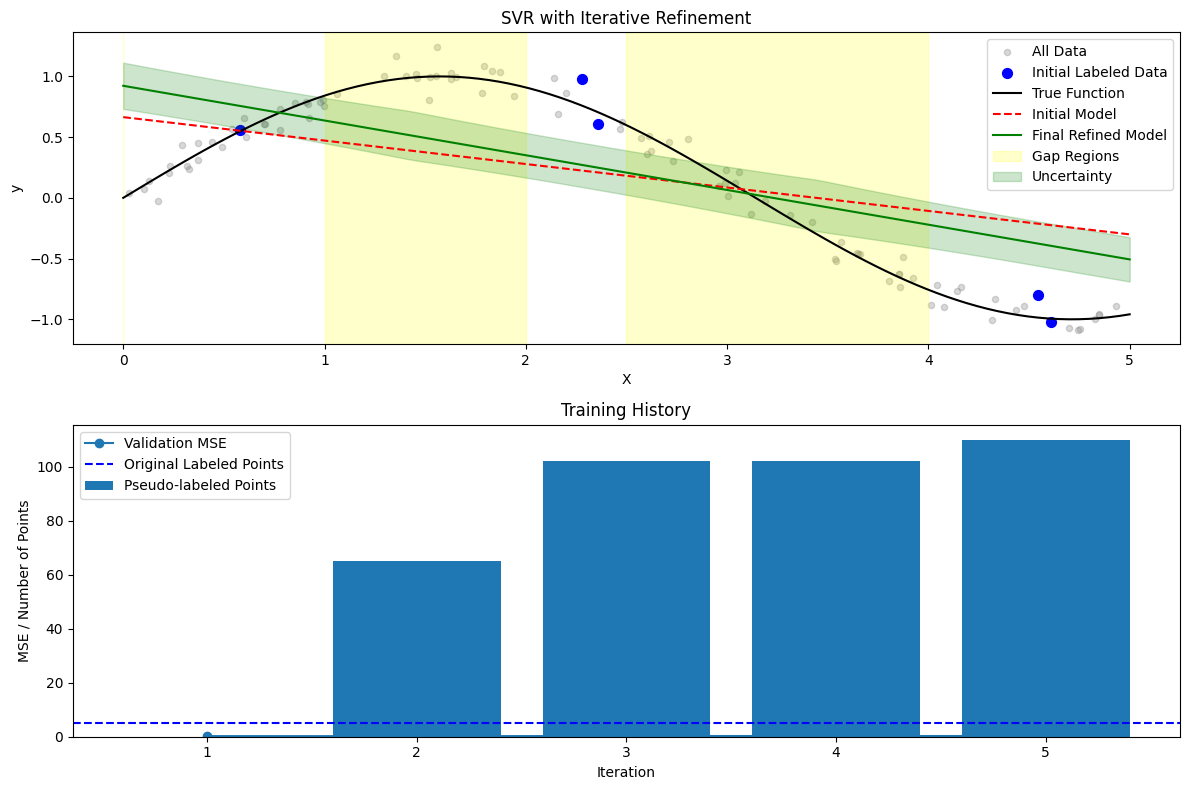


Improvement in MSE: 13.19%
Improvement in R²: 7.58 percentage points
Number of pseudo-labels used: 1
Ratio of pseudo-labels to initial labels: 0.20

--- Applying to a more realistic dataset example ---
Training with 20 labeled and 220 unlabeled points

--- Iteration 1 ---
Trained SVR with 20 data points (0 pseudo-labeled).
Validation MSE: 0.0603
Selected 174 high-confidence pseudo-labels (avg uncertainty: 0.1887).

--- Iteration 2 ---
Trained SVR with 194 data points (174 pseudo-labeled).
Validation MSE: 0.0616
No improvement for 1 iterations.
Selected 2 high-confidence pseudo-labels (avg uncertainty: 0.2101).

--- Iteration 3 ---
Trained SVR with 196 data points (176 pseudo-labeled).
Validation MSE: 0.0621
No improvement for 2 iterations.
Early stopping triggered after 3 iterations.
Using best model from iteration with validation MSE: 0.0603
Simple Model MSE: 0.9537, R²: 0.4569
Refined Model MSE: 0.9537, R²: 0.4569
Improvement: 0.00%


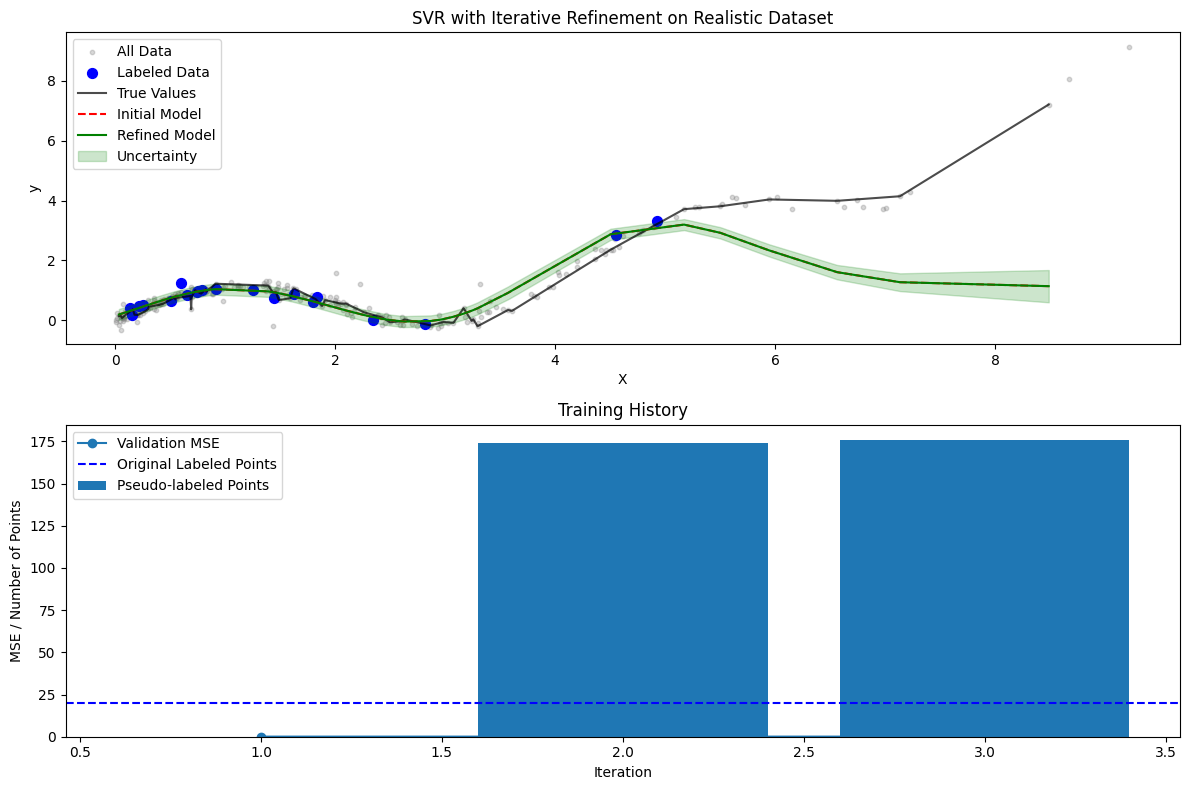

In [17]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


def train_svr(X, y, C=1.0, epsilon=0.1, kernel='rbf', scaler_type='standard'):
    """Trains an SVR model with choice of scaler.

    Args:
        X: Input features
        y: Target values
        C: Regularization parameter
        epsilon: Epsilon parameter for SVR
        kernel: Kernel type ('rbf', 'linear', 'poly', etc.)
        scaler_type: Type of scaler ('standard' or 'robust')

    Returns:
        model: Trained SVR model
        scaler_X: Fitted scaler for input features
    """
    # Choose scaler based on parameter
    if scaler_type == 'robust':
        scaler_X = RobustScaler()
    else:
        scaler_X = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(X_scaled, y)

    # Store X for later reference in uncertainty estimation
    model.X = X

    return model, scaler_X


def predict_with_svr(model, scaler_X, X_new):
    """Predicts using a trained SVR model.

    Args:
        model: Trained SVR model
        scaler_X: Fitted scaler for input features
        X_new: New data to predict on

    Returns:
        Predictions for X_new
    """
    X_new_scaled = scaler_X.transform(X_new)
    return model.predict(X_new_scaled)


def estimate_uncertainty_svr(model, scaler_X, X_predict):
    """Estimates uncertainty for SVR predictions based on distance to support vectors.

    This approach uses the distance to nearest support vector as a proxy for
    prediction uncertainty. Points far from any support vector will have higher uncertainty.

    Args:
        model: Trained SVR model
        scaler_X: Fitted scaler for input features
        X_predict: Data points for which to estimate uncertainty

    Returns:
        uncertainty: Uncertainty score for each prediction point
    """
    X_predict_scaled = scaler_X.transform(X_predict)
    support_vectors_scaled = model.support_vectors_

    if support_vectors_scaled.shape[0] > 0:
        # Calculate squared Euclidean distances to all support vectors
        distances = cdist(X_predict_scaled, support_vectors_scaled, metric='sqeuclidean')

        # Find distance to closest support vector for each point
        min_distances = np.min(distances, axis=1)

        # Calculate maximum possible distance for normalization
        # This uses the training data stored in model.X
        max_dist = np.max(cdist(scaler_X.transform(model.X), support_vectors_scaled,
                               metric='sqeuclidean')) if model.X.shape[0] > 0 and support_vectors_scaled.shape[0] > 0 else 1.0

        # Normalize distances to [0, 1] range and apply a sigmoid-like transformation
        # for more intuitive uncertainty values
        uncertainty = 1.0 / (1.0 + np.exp(-3 * (min_distances / (max_dist + 1e-6) - 0.5)))
    else:
        # If no support vectors (unlikely), assign maximum uncertainty
        uncertainty = np.ones(X_predict.shape[0])

    return uncertainty


def weighted_svr_fit(X, y, uncertainties=None, C=1.0, epsilon=0.1, kernel='rbf'):
    """Fits an SVR model with sample weights based on uncertainties.

    Args:
        X: Input features
        y: Target values
        uncertainties: Uncertainty scores for each sample (None for uniform weights)
        C, epsilon, kernel: SVR parameters

    Returns:
        Trained SVR model
    """
    if uncertainties is not None:
        # Convert uncertainties to weights (lower uncertainty -> higher weight)
        sample_weights = 1.0 / (uncertainties + 0.1)  # Adding 0.1 to avoid division by zero

        # Normalize weights to sum to n_samples for stability
        sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)
    else:
        sample_weights = None

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(X_scaled, y, sample_weight=sample_weights)

    # Store X for later reference
    model.X = X

    return model, scaler_X


def iterative_refinement_svr(X_labeled, y_labeled, X_unlabeled, initial_C=1.0, initial_epsilon=0.1,
                             kernel='rbf', uncertainty_threshold=0.5, max_iterations=5,
                             validation_set=None, early_stopping=True, patience=2):
    """Performs iterative refinement using SVR with pseudo-labeling.

    Args:
        X_labeled: Initial labeled feature data
        y_labeled: Initial labeled target values
        X_unlabeled: Unlabeled feature data
        initial_C: Initial C parameter for SVR
        initial_epsilon: Initial epsilon parameter for SVR
        kernel: Kernel type for SVR
        uncertainty_threshold: Threshold below which predictions are considered confident
        max_iterations: Maximum number of refinement iterations
        validation_set: Optional (X_val, y_val) tuple for validation
        early_stopping: Whether to use early stopping
        patience: Number of iterations without improvement before stopping

    Returns:
        final_model: Final trained SVR model
        final_scaler_X: Final scaler for the model
        history: Dictionary with training history metrics
    """
    current_X_train = X_labeled.copy()
    current_y_train = y_labeled.copy()

    # Keep track of unlabeled data and their pseudo-labels and uncertainties
    X_remaining = X_unlabeled.copy()

    # For keeping track of performance history
    history = {
        'iterations': [],
        'num_labeled': [],
        'num_pseudo': [],
        'validation_mse': [],
        'model_params': []
    }

    # For early stopping
    best_val_mse = float('inf')
    no_improvement_count = 0
    best_model = None
    best_scaler = None

    # Store pseudo-labels and their uncertainties for weighted learning
    pseudo_label_data = {
        'X': np.empty((0, X_labeled.shape[1])),
        'y': np.empty(0),
        'uncertainty': np.empty(0)
    }

    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration + 1} ---")

        # Train SVR on the current labeled data
        model, scaler_X = train_svr(current_X_train, current_y_train,
                                   C=initial_C, epsilon=initial_epsilon, kernel=kernel)

        history['iterations'].append(iteration + 1)
        history['num_labeled'].append(len(X_labeled))
        history['num_pseudo'].append(len(current_X_train) - len(X_labeled))
        history['model_params'].append({'C': initial_C, 'epsilon': initial_epsilon, 'kernel': kernel})

        print(f"Trained SVR with {len(current_X_train)} data points "
              f"({len(current_X_train) - len(X_labeled)} pseudo-labeled).")

        # Validate model if validation set is provided
        if validation_set is not None:
            X_val, y_val = validation_set
            y_val_pred = predict_with_svr(model, scaler_X, X_val)
            val_mse = mean_squared_error(y_val, y_val_pred)
            history['validation_mse'].append(val_mse)
            print(f"Validation MSE: {val_mse:.4f}")

            # Check for early stopping
            if early_stopping:
                if val_mse < best_val_mse:
                    best_val_mse = val_mse
                    no_improvement_count = 0
                    best_model = model
                    best_scaler = scaler_X
                else:
                    no_improvement_count += 1
                    print(f"No improvement for {no_improvement_count} iterations.")

                if no_improvement_count >= patience:
                    print(f"Early stopping triggered after {iteration + 1} iterations.")
                    break

        if X_remaining.shape[0] == 0:
            print("No more unlabeled data.")
            break

        # Predict on remaining unlabeled data and estimate uncertainty
        y_predicted = predict_with_svr(model, scaler_X, X_remaining)
        uncertainties = estimate_uncertainty_svr(model, scaler_X, X_remaining)

        # Select high-confidence pseudo-labels (lower uncertainty is higher confidence)
        high_confidence_indices = np.where(uncertainties < uncertainty_threshold)[0]

        if len(high_confidence_indices) == 0:
            print("No high-confidence pseudo-labels found in this iteration.")

            # Adjust uncertainty threshold if no samples were selected
            uncertainty_threshold *= 1.2
            print(f"Increased uncertainty threshold to {uncertainty_threshold:.4f}")

            # If we've tried increasing threshold and still no samples, break
            if uncertainty_threshold > 0.9:
                print("Uncertainty threshold too high. Stopping refinement.")
                break

            continue

        X_pseudo_labeled = X_remaining[high_confidence_indices]
        y_pseudo_labeled = y_predicted[high_confidence_indices]
        uncertainties_selected = uncertainties[high_confidence_indices]

        print(f"Selected {len(X_pseudo_labeled)} high-confidence pseudo-labels "
              f"(avg uncertainty: {np.mean(uncertainties_selected):.4f}).")

        # Store pseudo-labeled data with uncertainties
        pseudo_label_data['X'] = np.vstack((pseudo_label_data['X'], X_pseudo_labeled))
        pseudo_label_data['y'] = np.append(pseudo_label_data['y'], y_pseudo_labeled)
        pseudo_label_data['uncertainty'] = np.append(pseudo_label_data['uncertainty'], uncertainties_selected)

        # Combine original labeled data with all pseudo-labeled data for next training
        current_X_train = np.vstack((X_labeled, pseudo_label_data['X']))
        current_y_train = np.append(y_labeled, pseudo_label_data['y'])

        # Remove the used pseudo-labeled data from the unlabeled set
        remaining_indices = np.setdiff1d(np.arange(X_remaining.shape[0]), high_confidence_indices)
        X_remaining = X_remaining[remaining_indices]

    # If early stopping was used and a better model was found, use that one
    if early_stopping and best_model is not None and validation_set is not None:
        print(f"Using best model from iteration with validation MSE: {best_val_mse:.4f}")
        final_model, final_scaler_X = best_model, best_scaler
    else:
        # Train final model on all data
        final_model, final_scaler_X = weighted_svr_fit(
            current_X_train, current_y_train,
            uncertainties=np.append(np.zeros(len(X_labeled)), pseudo_label_data['uncertainty']),
            C=initial_C, epsilon=initial_epsilon, kernel=kernel
        )

    return final_model, final_scaler_X, history


if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate a synthetic dataset with a non-linear function
    X_full = np.sort(5 * np.random.rand(100, 1), axis=0)
    y_full = np.sin(X_full).ravel() + 0.1 * np.random.randn(100)

    # Split into train, validation, and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_full, y_full, test_size=0.2, random_state=42)

    X_labeled, X_validation, y_labeled, y_validation = train_test_split(
        X_train_full, y_train_full, test_size=0.5, random_state=42)

    # Create deliberate gaps in the labeled data
    # First, sort the data points by X value
    sorted_indices = np.argsort(X_train_full.ravel())
    X_sorted = X_train_full[sorted_indices]
    y_sorted = y_train_full[sorted_indices]

    # Define regions to include/exclude (creating gaps)
    # This creates 3 separate regions with gaps in between
    region1_mask = X_sorted.ravel() < 1.0  # Include points below 1.0
    region2_mask = (X_sorted.ravel() > 2.0) & (X_sorted.ravel() < 2.5)  # Include points between 2.0 and 2.5
    region3_mask = X_sorted.ravel() > 4.0  # Include points above 4.0

    # Combine the masks to get indices of points in the allowed regions
    combined_mask = region1_mask | region2_mask | region3_mask
    allowed_indices = sorted_indices[combined_mask]

    # Select a subset of points from the allowed regions (e.g., 10 points)
    if len(allowed_indices) > 10:
        selected_indices = np.random.choice(allowed_indices, size=5, replace=False)
    else:
        selected_indices = allowed_indices

    # Create the labeled dataset with gaps
    X_labeled = X_train_full[selected_indices]
    y_labeled = y_train_full[selected_indices]

    # Print the distribution of labeled points to verify gaps
    print("X values of labeled points:", np.sort(X_labeled.ravel()))

    # Treat the remaining training data as unlabeled
    X_unlabeled = np.vstack([X_train_full[10:], X_validation])
    y_unlabeled_true = np.hstack([y_train_full[10:], y_validation])  # Only for evaluation

    # Automated hyperparameter selection for initial model
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'epsilon': [0.05, 0.1, 0.2],
        'kernel': [ 'linear']
    }

    scaler_X = StandardScaler()
    X_labeled_scaled = scaler_X.fit_transform(X_labeled)

    grid_search = GridSearchCV(
        SVR(), param_grid, cv=min(3, len(X_labeled)),
        scoring='neg_mean_squared_error'
    )

    grid_search.fit(X_labeled_scaled, y_labeled)
    best_params = grid_search.best_params_

    print(f"Best parameters from grid search: {best_params}")

    # Perform iterative refinement with the best parameters
    # Use a lower uncertainty threshold to be more selective with pseudo-labels
    # This helps ensure we only add high-quality pseudo-labels in the gap regions
    final_model, final_scaler, history = iterative_refinement_svr(
        X_labeled, y_labeled, X_unlabeled,
        initial_C=best_params['C'],
        initial_epsilon=best_params['epsilon'],
        kernel=best_params['kernel'],
        uncertainty_threshold=0.2,  # More selective threshold
        max_iterations=8,           # More iterations to allow gradual improvement
        validation_set=(X_validation, y_validation),
        early_stopping=True,
        patience=3                  # More patience to avoid stopping too early
    )

    # Evaluate the final model on test data
    y_pred_final = predict_with_svr(final_model, final_scaler, X_test)
    mse_final = mean_squared_error(y_test, y_pred_final)
    r2_final = r2_score(y_test, y_pred_final)
    print(f"\nFinal Model MSE on Test Data: {mse_final:.4f}")
    print(f"Final Model R² Score on Test Data: {r2_final:.4f}")

    # Compare with a model trained only on the initial labeled data
    initial_model, initial_scaler = train_svr(
        X_labeled, y_labeled,
        C=best_params['C'],
        epsilon=best_params['epsilon'],
        kernel=best_params['kernel']
    )

    y_pred_initial = predict_with_svr(initial_model, initial_scaler, X_test)
    mse_initial = mean_squared_error(y_test, y_pred_initial)
    r2_initial = r2_score(y_test, y_pred_initial)
    print(f"Initial Model MSE on Test Data: {mse_initial:.4f}")
    print(f"Initial Model R² Score on Test Data: {r2_initial:.4f}")

    # Evaluate specific performance in gap regions
    gap_regions = [
        (1.0, 2.0),  # First gap
        (2.5, 4.0)   # Second gap
    ]

    print("\nPerformance in gap regions:")
    for i, (gap_start, gap_end) in enumerate(gap_regions):
        # Find test points in this gap
        gap_mask = (X_test.ravel() > gap_start) & (X_test.ravel() < gap_end)
        if np.sum(gap_mask) > 0:
            X_gap = X_test[gap_mask]
            y_gap = y_test[gap_mask]

            # Evaluate initial model in gap
            y_gap_initial = predict_with_svr(initial_model, initial_scaler, X_gap)
            mse_gap_initial = mean_squared_error(y_gap, y_gap_initial)

            # Evaluate final model in gap
            y_gap_final = predict_with_svr(final_model, final_scaler, X_gap)
            mse_gap_final = mean_squared_error(y_gap, y_gap_final)

            improvement = (mse_gap_initial - mse_gap_final) / mse_gap_initial * 100
            print(f"  Gap {i+1} ({gap_start}-{gap_end}): Initial MSE = {mse_gap_initial:.4f}, "
                  f"Final MSE = {mse_gap_final:.4f}, Improvement = {improvement:.2f}%")

    # Visualize results
    X_plot = np.linspace(0, 5, 100).reshape(-1, 1)
    y_plot_true = np.sin(X_plot).ravel()
    y_plot_initial = predict_with_svr(initial_model, initial_scaler, X_plot)
    y_plot_final = predict_with_svr(final_model, final_scaler, X_plot)

    plt.figure(figsize=(12, 8))

    # Create a subplot for the final model and predictions
    plt.subplot(2, 1, 1)
    plt.scatter(X_full, y_full, s=20, label='All Data', alpha=0.3, color='gray')
    plt.scatter(X_labeled, y_labeled, s=50, label='Initial Labeled Data', color='blue')
    plt.plot(X_plot, y_plot_true, label='True Function', color='black')
    plt.plot(X_plot, y_plot_initial, label='Initial Model', color='red', linestyle='--')
    plt.plot(X_plot, y_plot_final, label='Final Refined Model', color='green')

    # Highlight the gap regions
    gap_regions = [
        (1.0, 2.0),  # First gap
        (2.5, 4.0)   # Second gap
    ]

    for gap_start, gap_end in gap_regions:
        plt.axvspan(gap_start, gap_end, alpha=0.2, color='yellow', label='_Gap Region')

    # Add a label for gap regions (only once in the legend)
    plt.axvspan(0, 0, alpha=0.2, color='yellow', label='Gap Regions')

    # Plot uncertainty for final model
    uncertainties = estimate_uncertainty_svr(final_model, final_scaler, X_plot)
    upper_bound = y_plot_final + uncertainties
    lower_bound = y_plot_final - uncertainties
    plt.fill_between(X_plot.ravel(), lower_bound, upper_bound, alpha=0.2, color='green', label='Uncertainty')

    plt.title('SVR with Iterative Refinement')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

    # Create a subplot for the training history
    plt.subplot(2, 1, 2)
    iterations = history['iterations']

    if history['validation_mse']:
        plt.plot(iterations, history['validation_mse'], 'o-', label='Validation MSE')

    plt.bar(iterations, history['num_pseudo'], label='Pseudo-labeled Points')
    plt.axhline(y=len(X_labeled), linestyle='--', color='blue', label='Original Labeled Points')

    plt.title('Training History')
    plt.xlabel('Iteration')
    plt.ylabel('MSE / Number of Points')
    plt.legend()

    plt.tight_layout()
    plt.savefig('svr_refinement_results.png')
    plt.show()

    # Calculate improvement metrics
    improvement_mse = (mse_initial - mse_final) / mse_initial * 100
    improvement_r2 = (r2_final - r2_initial) * 100

    print(f"\nImprovement in MSE: {improvement_mse:.2f}%")
    print(f"Improvement in R²: {improvement_r2:.2f} percentage points")

    # Calculate statistics on pseudo-labeling
    try:
        total_pseudo_labels = final_model.support_.shape[0] - X_labeled.shape[0]
        print(f"Number of pseudo-labels used: {total_pseudo_labels}")
        print(f"Ratio of pseudo-labels to initial labels: {total_pseudo_labels/X_labeled.shape[0]:.2f}")
    except:
        print("Could not calculate support vector statistics.")

    # Additional example: Apply the method to a more realistic dataset
    print("\n--- Applying to a more realistic dataset example ---")

    # Create a more complex but similar 1D dataset (with some noise and outliers)
    np.random.seed(42)
    n_samples = 300

    # Input features - non-uniform distribution
    X_real = np.random.exponential(scale=2.0, size=(n_samples, 1))
    X_real = np.sort(X_real, axis=0)
    X_real = np.clip(X_real, 0, 10)  # Limit range

    # Target values - combination of sine and linear trend with varying noise
    noise = 0.2 * np.random.randn(n_samples)
    # Add some heteroscedastic noise (more noise for larger x values)
    noise = noise * (0.5 + 0.5 * X_real.ravel() / 10.0)
    # Add some outliers
    outlier_idx = np.random.choice(n_samples, size=15, replace=False)
    noise[outlier_idx] = noise[outlier_idx] * 5

    # Underlying function: sine wave + linear trend
    y_real = np.sin(X_real.ravel() * 1.5) + 0.1 * X_real.ravel()**2 + noise

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

    # Simulate limited labeled data - choose points more from the beginning
    # This simulates a common real-world scenario where we have data for a limited input range
    sorted_indices = np.argsort(X_train.ravel())
    # Select 20 samples, with higher probability for lower X values
    p = np.exp(-X_train[sorted_indices].ravel()/3)
    p = p / p.sum()
    labeled_indices = np.random.choice(sorted_indices, size=20, replace=False, p=p)

    X_labeled = X_train[labeled_indices]
    y_labeled = y_train[labeled_indices]

    # Remove labeled data from training set to get unlabeled set
    unlabeled_indices = np.setdiff1d(np.arange(len(X_train)), labeled_indices)
    X_unlabeled = X_train[unlabeled_indices]
    y_unlabeled = y_train[unlabeled_indices]  # Only for evaluation

    # Train models
    print(f"Training with {len(X_labeled)} labeled and {len(X_unlabeled)} unlabeled points")

    # Create a validation set
    X_val, X_unlabeled, y_val, y_unlabeled = train_test_split(
        X_unlabeled, y_unlabeled, test_size=0.8, random_state=42)

    # Train simple model with only labeled data
    simple_model, simple_scaler = train_svr(X_labeled, y_labeled, C=10.0, epsilon=0.1)

    # Train refined model with pseudo-labeling
    refined_model, refined_scaler, history = iterative_refinement_svr(
        X_labeled, y_labeled, X_unlabeled,
        initial_C=10.0,
        initial_epsilon=0.1,
        uncertainty_threshold=0.4,
        max_iterations=5,
        validation_set=(X_val, y_val)
    )

    # Evaluate
    y_pred_simple = predict_with_svr(simple_model, simple_scaler, X_test)
    y_pred_refined = predict_with_svr(refined_model, refined_scaler, X_test)

    mse_simple = mean_squared_error(y_test, y_pred_simple)
    mse_refined = mean_squared_error(y_test, y_pred_refined)
    r2_simple = r2_score(y_test, y_pred_simple)
    r2_refined = r2_score(y_test, y_pred_refined)

    print(f"Simple Model MSE: {mse_simple:.4f}, R²: {r2_simple:.4f}")
    print(f"Refined Model MSE: {mse_refined:.4f}, R²: {r2_refined:.4f}")
    print(f"Improvement: {(mse_simple - mse_refined) / mse_simple * 100:.2f}%")

    # Visualize more realistic dataset results
    plt.figure(figsize=(12, 8))

    # Plot data and predictions
    plt.subplot(2, 1, 1)
    plt.scatter(X_real, y_real, s=10, alpha=0.3, label='All Data', color='gray')
    plt.scatter(X_labeled, y_labeled, s=50, label='Labeled Data', color='blue')

    # Sort X_test for smooth plotting
    sort_idx = np.argsort(X_test.ravel())
    X_test_sorted = X_test[sort_idx]
    y_test_sorted = y_test[sort_idx]
    y_simple_sorted = y_pred_simple[sort_idx]
    y_refined_sorted = y_pred_refined[sort_idx]

    # Plot true values and predictions
    plt.plot(X_test_sorted, y_test_sorted, 'k-', label='True Values', alpha=0.7)
    plt.plot(X_test_sorted, y_simple_sorted, 'r--', label='Initial Model')
    plt.plot(X_test_sorted, y_refined_sorted, 'g-', label='Refined Model')

    # Plot uncertainty
    uncertainties = estimate_uncertainty_svr(refined_model, refined_scaler, X_test_sorted)
    plt.fill_between(
        X_test_sorted.ravel(),
        y_refined_sorted - uncertainties,
        y_refined_sorted + uncertainties,
        alpha=0.2, color='green', label='Uncertainty'
    )

    plt.title('SVR with Iterative Refinement on Realistic Dataset')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()

    # Plot validation error and pseudo-label counts
    plt.subplot(2, 1, 2)
    iterations = history['iterations']

    if history['validation_mse']:
        plt.plot(iterations, history['validation_mse'], 'o-', label='Validation MSE')

    plt.bar(iterations, history['num_pseudo'], label='Pseudo-labeled Points')
    plt.axhline(y=len(X_labeled), linestyle='--', color='blue', label='Original Labeled Points')

    plt.title('Training History')
    plt.xlabel('Iteration')
    plt.ylabel('MSE / Number of Points')
    plt.legend()

    plt.tight_layout()
    plt.savefig('svr_refinement_realistic.png')
    plt.show()